In [231]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from wordcloud import WordCloud

# mission1 散点图

In [1]:
def plotit(filename):
    plot = pd.read_csv(filename, sep="\t", header=None)
    plt.scatter(plot[0], plot[1], c=plot[2])

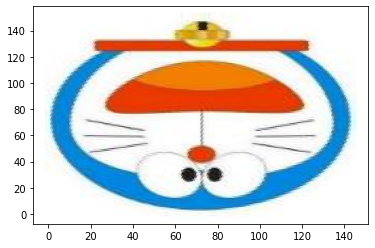

In [2]:
plotit("mission1/task1.txt")

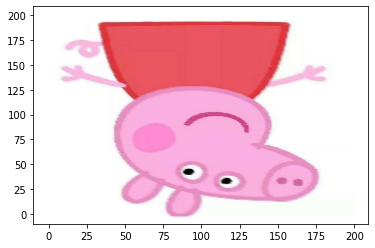

In [3]:
plotit("mission1/task2.txt")

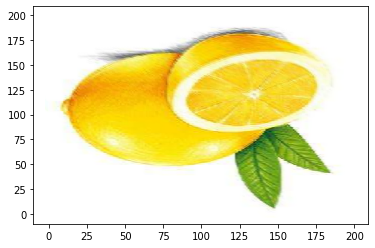

In [4]:
plotit("mission1/task3.txt")

# mission2  人名

In [2]:
import jieba.posseg

# 1. 请分别统计“射雕英雄传.txt”、“鹿鼎记.txt”、“笑傲江湖.txt”中最重要的10个人名展示，并且画出统计直方图（柱状图）

In [26]:
def getnames(filename = 'mission2/射雕英雄传.txt'):
    names = {}
    with open(filename) as f:
        for k, v in jieba.posseg.lcut(f.read()):
            if v == 'nr':
                names[k] = names.get(k, 0) + 1 
    return names

def names2table(names):
    return pd.DataFrame([names.keys(), names.values()]).transpose().sort_values(by=1, ascending=False)

def draw_wordcloud(names):
    wc = WordCloud(font_path='/home/sor/simhei.ttf', background_color="white", max_words=1000)
    wc.generate_from_frequencies(names)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def draw_bar(dat):
    plt.bar(dat[:10][0], dat[:10][1])

# 人名频率

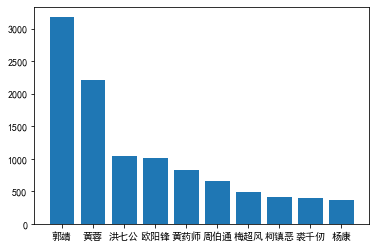

In [37]:
names = getnames('mission2/射雕英雄传.txt')
dat = names2table(names)

dat.drop(dat[dat[0] == '武功'].index, inplace=True)
dat.drop(dat[dat[0] == '後'].index, inplace=True)

draw_bar(dat)

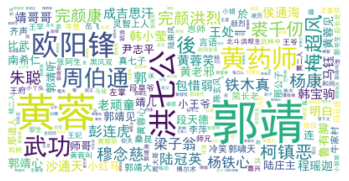

In [31]:
draw_wordcloud(names)

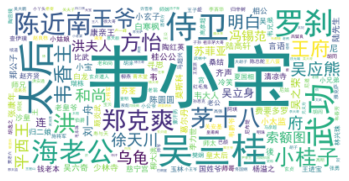

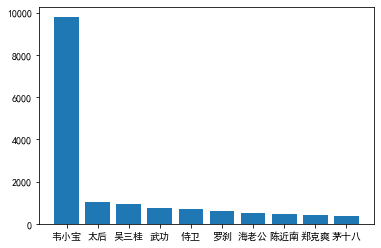

In [36]:
names = getnames('mission2/鹿鼎记.txt')
dat = names2table(names)

draw_wordcloud(names)
draw_bar(dat)

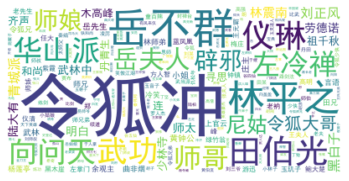

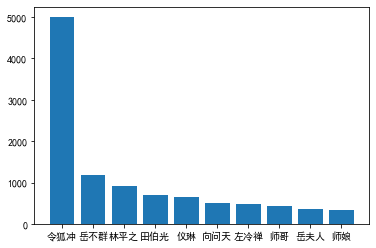

In [41]:
names = getnames('mission2/笑傲江湖.txt')
dat = names2table(names)

dat.drop(dat[dat[0] == '武功'].index, inplace=True)
dat.drop(dat[dat[0] == '华山派'].index, inplace=True)

draw_wordcloud(names)
draw_bar(dat)

# 2.根据“射雕英雄传.txt”文本的内容，计算出人名之间的两两相似度，使用Kmeans对人名聚类

In [81]:
import jieba
from gensim.models import word2vec

with open('mission2/射雕英雄传.txt') as f:
    jieba_cut = [i for i in jieba.cut(f.read())]

In [128]:
model = word2vec.Word2Vec(window=3, size=100)
model.build_vocab(np.array_split(jieba_cut, 100000))

In [132]:
model.train(jieba_cut, total_examples=model.corpus_count, epochs=5)

(3280072, 4536055)

In [143]:
names = getnames('mission2/射雕英雄传.txt')
dat = names2table(names)

In [150]:
dat.drop(dat[dat[0] == '武功'].index, inplace=True)
dat.drop(dat[dat[0] == '後'].index, inplace=True)

# 相似度

In [172]:
top10names = dat[:10][0]

pd.DataFrame([[model.wv.similarity(top10names.iloc[i], top10names.iloc[j])
                       for j in range(10)]
                  for i in range(10)],
             index=list(top10names), columns=list(top10names))

,郭靖,黄蓉,洪七公,欧阳锋,黄药师,周伯通,梅超风,柯镇恶,裘千仞,杨康
郭靖,1.000000,-0.080106,-0.117159,0.049684,0.064652,-0.059006,-0.077347,0.007204,-0.026727,0.014361
黄蓉,-0.080106,1.000000,-0.209556,0.009250,0.001793,0.000385,0.037312,-0.098960,0.009140,-0.018024
洪七公,-0.117159,-0.209556,1.000000,-0.025596,-0.011061,-0.122844,-0.199427,-0.113075,0.103896,0.072332
欧阳锋,0.049684,0.009250,-0.025596,1.000000,0.088520,0.082069,0.008460,0.083637,-0.051754,-0.132712
黄药师,0.064652,0.001793,-0.011061,0.088520,1.000000,0.072731,-0.029405,0.034663,0.170711,-0.116911
周伯通,-0.059006,0.000385,-0.122844,0.082069,0.072731,1.000000,-0.019667,0.027970,-0.299707,-0.155363
梅超风,-0.077347,0.037312,-0.199427,0.008460,-0.029405,-0.019667,1.000000,-0.011440,0.062741,0.019324
柯镇恶,0.007204,-0.098960,-0.113075,0.083637,0.034663,0.027970,-0.011440,1.000000,0.003691,-0.311075
裘千仞,-0.026727,0.009140,0.103896,-0.051754,0.170711,-0.299707,0.062741,0.003691,1.000000,-0.088562
杨康,0.014361,-0.018024,0.072332,-0.132712,-0.116911,-0.155363,0.019324,-0.311075,-0.088562,1.000000


In [ ]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=2).fit_transform(model.wv.vectors)

def wordreduced(word):
    index = model.wv.vocab[word].index
    return (X_reduced[index][0], X_reduced[index][1])

# 二维空间中显示词向量

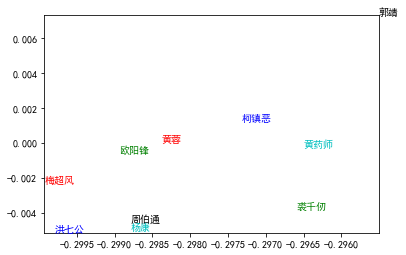

In [408]:
def pca2dplot(centers, markers = list('.o+v1s*'), colormap = list('krbgckrbgc'), simn = 0):
    centers = list(centers)
    fig = plt.figure()
    ax = fig.add_subplot()
    xs, ys = [], []
    
    for i in range(len(centers)):
        toplot = ([(*wordreduced(centers[i]), centers[i])] +
            [(*wordreduced(item[0]), item[0]) for item in model.wv.most_similar(centers[i], topn=simn)])
        for x in toplot: ax.text(*x, color = colormap[i])

        a = np.array(toplot).transpose()
        xs += list(a[0].astype(float))
        ys += list(a[1].astype(float))
    ax.axis([min(xs), max(xs), min(ys), max(ys)])
pca2dplot(top10names)

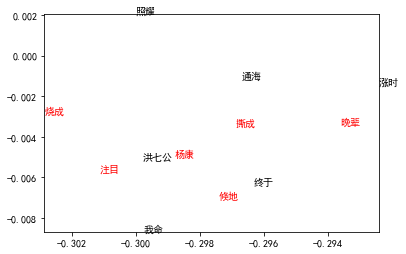

In [395]:
pca2dplot(['洪七公', '杨康'], simn=5)

# mission3 北京的房价

In [2]:
dat = pd.read_csv("mission3/beijing.csv")

sum_price = dat["总价"]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1.1. 最高房价成交记录

In [11]:
dat.loc[sum_price.idxmax()]

id        101101263750 
经度              116.469
维度               39.979
交易时间/年             2017
交易时间/月                3
交易时间/日               30
关注数                   0
总价                18130
面积               1745.5
起居室                   6
会客厅                   3
厨房                    1
洗手间                   4
楼层                    4
建筑时间               2008
是否有电梯                 0
是否靠近地铁                0
小区均价              88345
Name: 67868, dtype: object

## 1.2. 最低房价成交记录

In [12]:
dat.loc[sum_price.idxmin()]

id        BJCP00370589
经度             116.446
维度             40.0777
交易时间/年            2011
交易时间/月               9
交易时间/日              22
关注数                  0
总价                 0.1
面积                 110
起居室                  2
会客厅                  1
厨房                   1
洗手间                  1
楼层                   7
建筑时间              2002
是否有电梯                0
是否靠近地铁               0
小区均价             36411
Name: 92969, dtype: object

## 2. 关注度最高的成交记录

In [13]:
attention = dat["关注数"]
dat.loc[attention.idxmax()]

id        101101590746 
经度              116.343
维度              39.9005
交易时间/年             2017
交易时间/月               12
交易时间/日               31
关注数                1143
总价                  380
面积                32.54
起居室                   1
会客厅                   1
厨房                    1
洗手间                   2
楼层                   10
建筑时间               2005
是否有电梯                 1
是否靠近地铁                1
小区均价              92360
Name: 76267, dtype: object

## 3. 各年度北京每平方米的房价均值

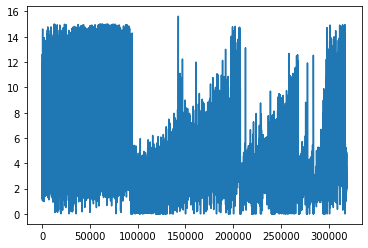

In [14]:
dat["avg"] = dat["总价"]/dat["面积"]
plt.plot(dat["avg"])

## 4. 靠近地铁和不靠近地铁的每平方米房价均值

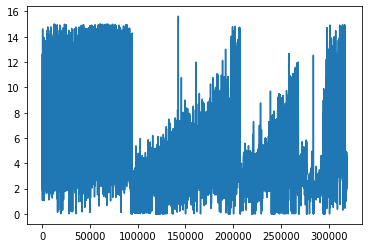

In [15]:
plt.plot((dat[dat["是否靠近地铁"] == 1])["avg"])

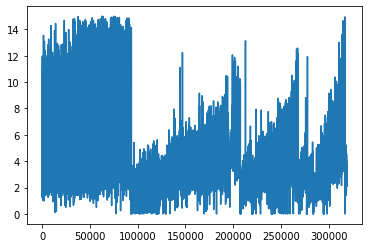

In [16]:
plt.plot((dat[dat["是否靠近地铁"] == 0])["avg"])

## 5. 哪个月份买房的人最多？哪个月份买房的人最少？每个月份购买的人数占比是多少？

交易时间/月
3     38052
12    31643
8     30628
9     28086
7     26660
11    24986
10    24851
1     24470
6     23684
2     22661
5     22082
4     21048
Name: count, dtype: int64

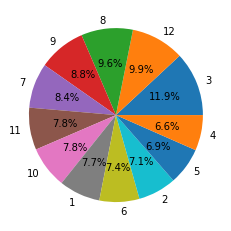

In [4]:
dat["count"] = 1
a = dat.groupby("交易时间/月").sum().sort_values(by="count", ascending=False)
plt.pie(a["count"], labels=a.index, autopct='%1.1f%%')
a["count"]

## 可以看出三月买房的人最多，四月最少

# 6. 取出2017年12月的成交数据

In [32]:
dat[(dat['交易时间/年'] == 2017) & (dat['交易时间/月'] == 12)]

,id,经度,维度,交易时间/年,交易时间/月,交易时间/日,关注数,总价,面积,起居室,会客厅,厨房,洗手间,楼层,建筑时间,是否有电梯,是否靠近地铁,小区均价,count
11369,101092339947,116.560168,40.110054,2017,12,13,237,850.0,216.50,4,2,1,3,3,1999,0.0,0,44446.0,1
25469,101100394673,116.392080,39.951543,2017,12,5,142,638.0,59.80,2,1,1,1,5,1989,0.0,1,113948.0,1
38813,101100616972,116.438800,40.054941,2017,12,20,65,440.0,57.70,1,1,1,1,27,2014,1.0,0,77695.0,1
39887,101100637798,116.374708,39.854229,2017,12,4,394,303.0,63.40,2,1,1,1,6,1998,0.0,1,56242.0,1
41760,101100676525,116.374459,39.995227,2017,12,31,103,508.8,73.80,2,1,1,1,18,1990,1.0,0,81499.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92200,101102445381,116.358797,40.083529,2017,12,31,0,420.0,94.15,2,1,1,1,5,2003,0.0,0,42145.0,1
92202,101102446302,116.426125,39.990760,2017,12,31,0,1300.0,266.86,1,1,1,1,1,鏈煡,0.0,1,70719.0,1
92204,101102446698,116.234832,40.223951,2017,12,31,0,157.0,47.01,1,1,1,1,2,鏈煡,0.0,1,40258.0,1
92205,101102447335,116.423905,39.791207,2017,12,31,0,413.0,89.78,2,1,1,1,10,2010,1.0,0,44880.0,1


# 采用线性回归/多项式回归的方法预测房价

,id,经度,维度,交易时间/年,交易时间/月,交易时间/日,关注数,总价,面积,起居室,会客厅,厨房,洗手间,楼层,建筑时间,是否有电梯,是否靠近地铁,小区均价,count
11369,101092339947,116.560168,40.110054,2017,12,13,237,850.0,216.50,4,2,1,3,3,1999,0.0,0,44446.0,1
25469,101100394673,116.392080,39.951543,2017,12,5,142,638.0,59.80,2,1,1,1,5,1989,0.0,1,113948.0,1
38813,101100616972,116.438800,40.054941,2017,12,20,65,440.0,57.70,1,1,1,1,27,2014,1.0,0,77695.0,1
39887,101100637798,116.374708,39.854229,2017,12,4,394,303.0,63.40,2,1,1,1,6,1998,0.0,1,56242.0,1
41760,101100676525,116.374459,39.995227,2017,12,31,103,508.8,73.80,2,1,1,1,18,1990,1.0,0,81499.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92200,101102445381,116.358797,40.083529,2017,12,31,0,420.0,94.15,2,1,1,1,5,2003,0.0,0,42145.0,1
92202,101102446302,116.426125,39.990760,2017,12,31,0,1300.0,266.86,1,1,1,1,1,鏈煡,0.0,1,70719.0,1
92204,101102446698,116.234832,40.223951,2017,12,31,0,157.0,47.01,1,1,1,1,2,鏈煡,0.0,1,40258.0,1
92205,101102447335,116.423905,39.791207,2017,12,31,0,413.0,89.78,2,1,1,1,10,2010,1.0,0,44880.0,1
